## **Marketing Promotion Campaign Uplift Modelling**    
#### Customer Retention data for Churn Prediction or Uplift Modelling

**Description / Задание:**  
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72,5% !important; }</style>"))

In [10]:
# !pip install scikit-uplift
# !pip install CatBoost

In [9]:
# !pip install causalml

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels

from catboost import CatBoostClassifier

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [7]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [62]:
TRAIN_DATASET_PATH = './data.csv'

### Загрузка данных

In [63]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

### Изучение датасета

In [64]:
# Количество строк и колонок в датафрейме
print(train_df.shape)

(64000, 9)


In [65]:
# Просмотр записей(строк) из начала датафрейма
train_df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44000,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08000,1,1,Rural,1,Web,No Offer,0
2,7,180.65000,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83000,1,0,Rural,1,Web,Discount,0
4,2,45.34000,1,0,Urban,0,Web,Buy One Get One,0


In [66]:
# Cведения о датафрейме
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [67]:
# Количественные переменные
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,64000.00000,5.76373,3.50759,1.00000,2.00000,6.00000,9.00000,12.00000
history,64000.00000,242.08566,256.15861,29.99000,64.66000,158.11000,325.65750,3345.93000
used_discount,64000.00000,0.55103,0.49739,0.00000,0.00000,1.00000,1.00000,1.00000
used_bogo,64000.00000,0.54972,0.49753,0.00000,0.00000,1.00000,1.00000,1.00000
is_referral,64000.00000,0.50225,0.50000,0.00000,0.00000,1.00000,1.00000,1.00000
conversion,64000.00000,0.14678,0.35389,0.00000,0.00000,0.00000,0.00000,1.00000


In [68]:
# Категориальные переменные
train_df.describe(include=['O']).T

,count,unique,top,freq
zip_code,64000,3,Surburban,28776
channel,64000,3,Web,28217
offer,64000,3,Buy One Get One,21387


In [69]:
# Категориальные переменные
train_df.describe(include=np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


### Работа с данными

In [70]:
# Пропуски в данных
train_df.isnull().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
offer            0
conversion       0
dtype: int64

In [71]:
# Переименование столбцов
def rename_func(df):    
    df.rename(columns={'conversion': 'target', 'offer': 'treatment', 
    }, inplace=True)
    
rename_func(train_df)

In [72]:
train_df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [73]:
# Преобразование из категориальной переменной в числовую.
train_df.loc[train_df['treatment'] == 'Buy One Get One', 'treatment'] = 1
train_df.loc[train_df['treatment'] == 'Discount', 'treatment'] = 1
train_df.loc[train_df['treatment'] == 'No Offer', 'treatment'] = 0

train_df['treatment'] = pd.to_numeric(train_df['treatment'])

In [74]:
# Проверяем результат записей(строк) из начала датафрейма
train_df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44000,1,0,Surburban,0,Phone,1,0
1,6,329.08000,1,1,Rural,1,Web,0,0
2,7,180.65000,0,1,Surburban,1,Web,1,0
3,9,675.83000,1,0,Rural,1,Web,1,0
4,2,45.34000,1,0,Urban,0,Web,1,0


### Подготовка признаков

In [75]:
X = pd.get_dummies(train_df)
X.drop('target', axis=1, inplace=True)
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Корреляция признаков

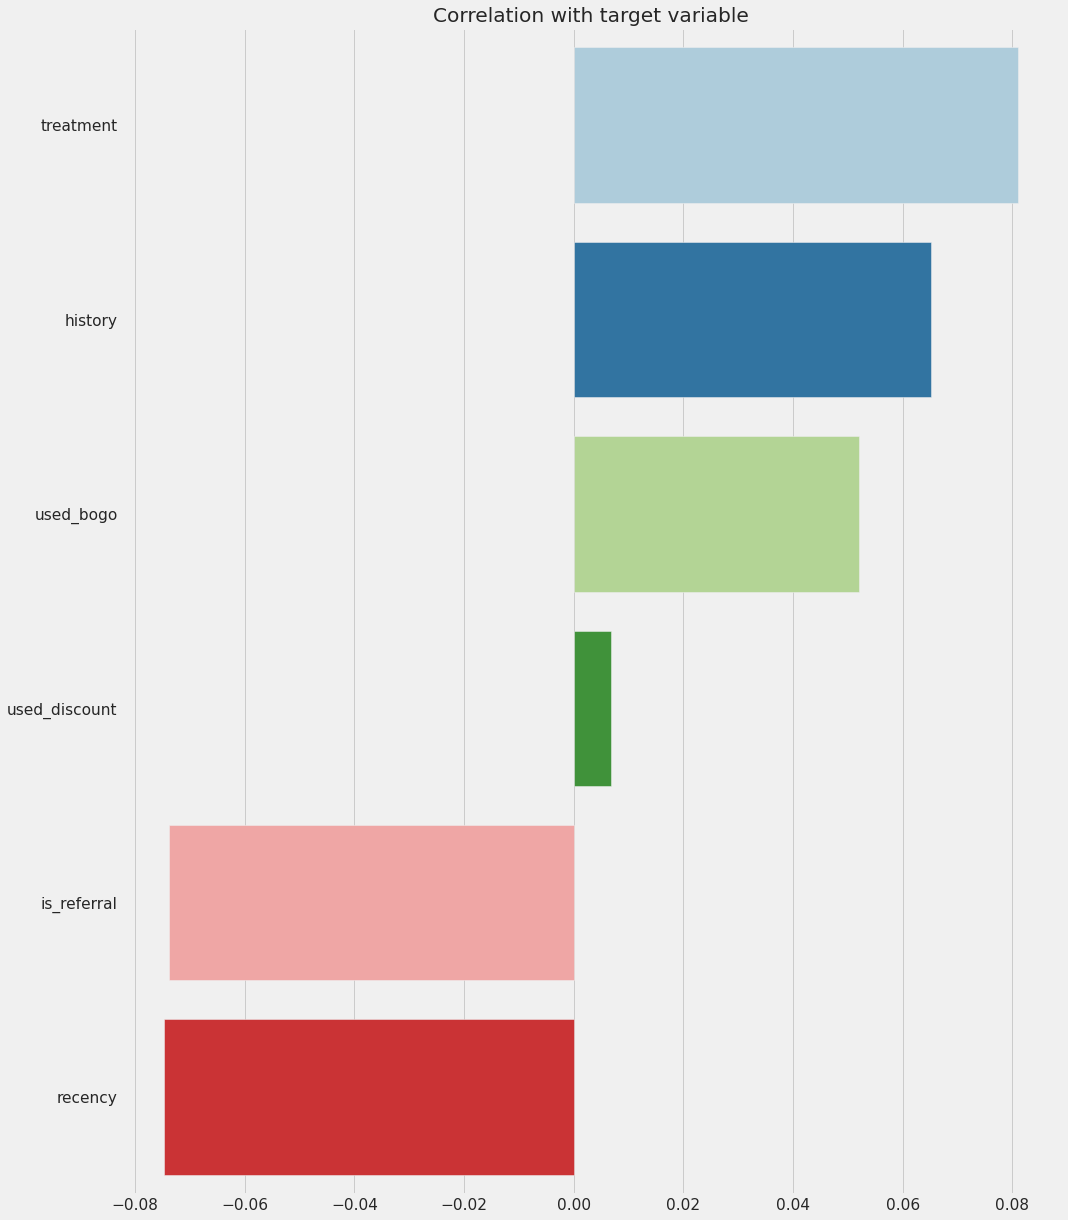

In [76]:
TARGET_NAME = 'target'

corr_with_target = train_df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

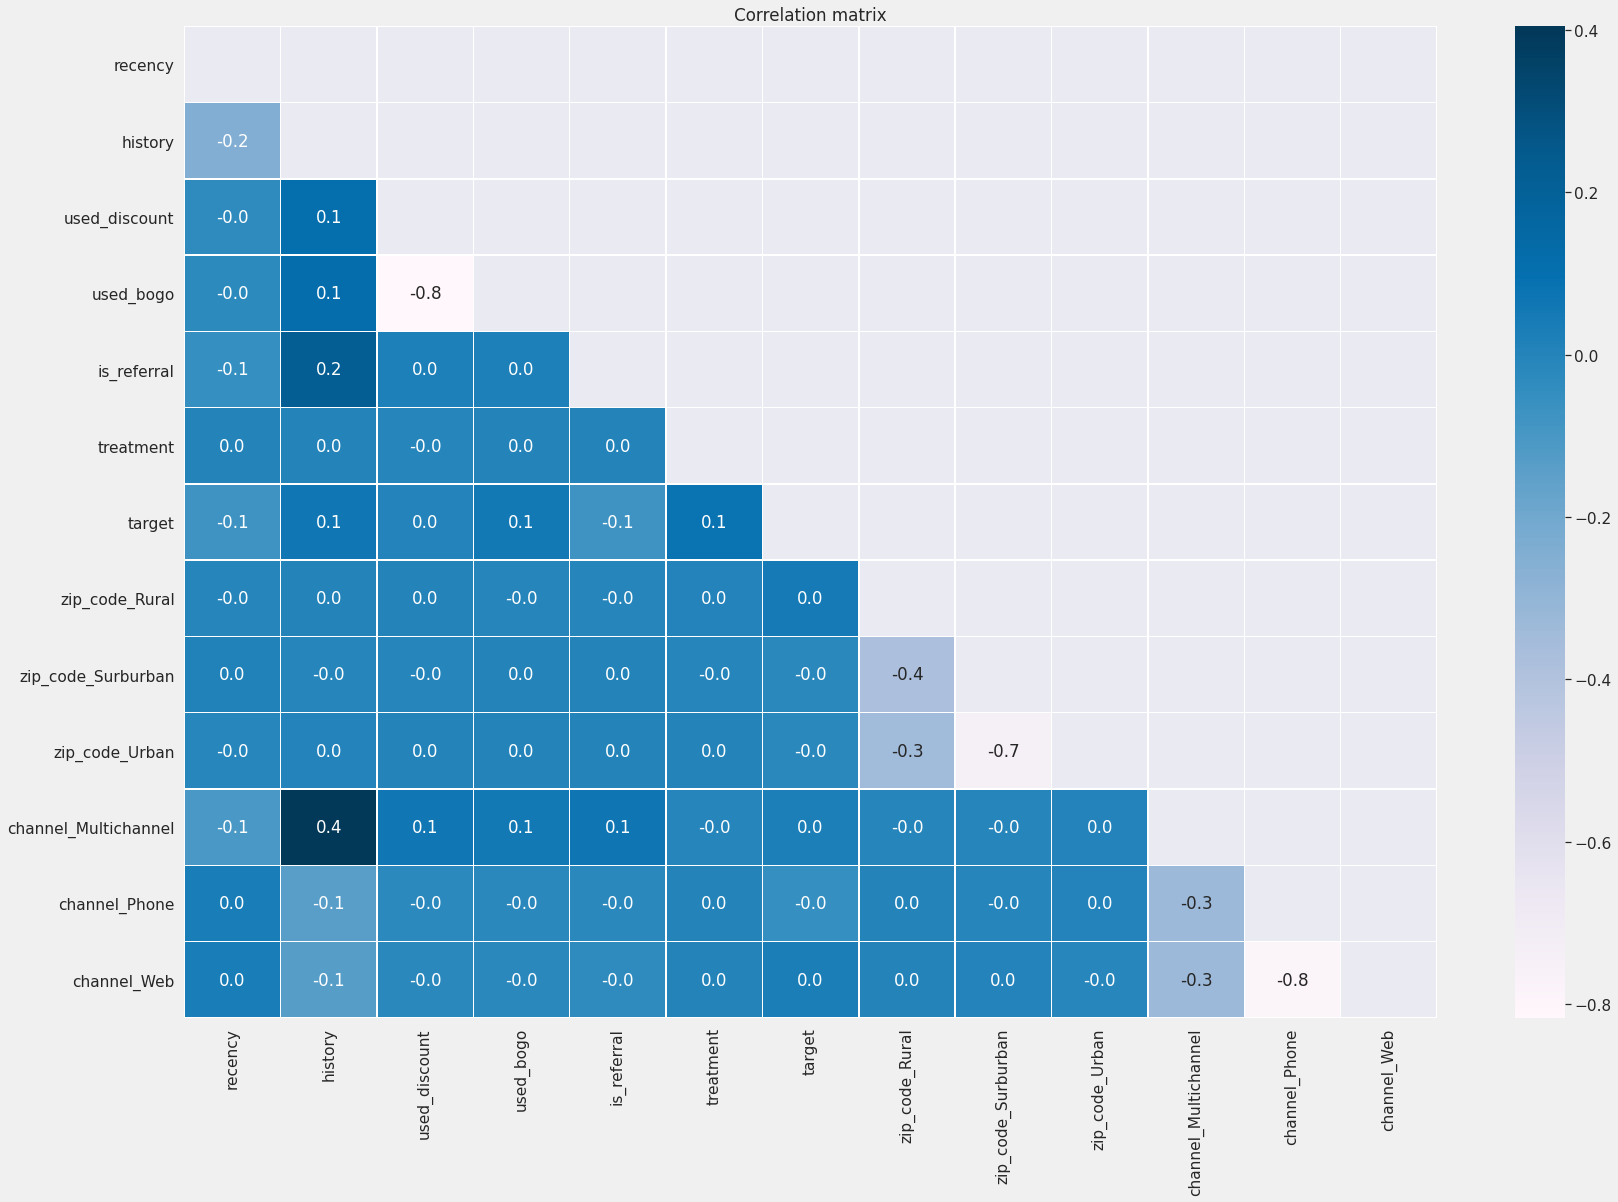

In [77]:
df_num_features = pd.get_dummies(train_df)
# df.select_dtypes(include = ['float64', 'int64'])
num_features = pd.DataFrame(df_num_features)

corr = num_features.corr()
plt.figure(figsize = (25, 17))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='PuBu')
plt.title('Correlation matrix')
plt.show();

In [78]:
# Split data with bogo and discount
# train_df_bogo = train_df().loc[train_df.treatment <=0].reset_index(drop=True)
# train_df_discount = train_df().loc[train_df.treatment >=0].reset_index(drop=True)

### Одна модель с признаком коммуникации

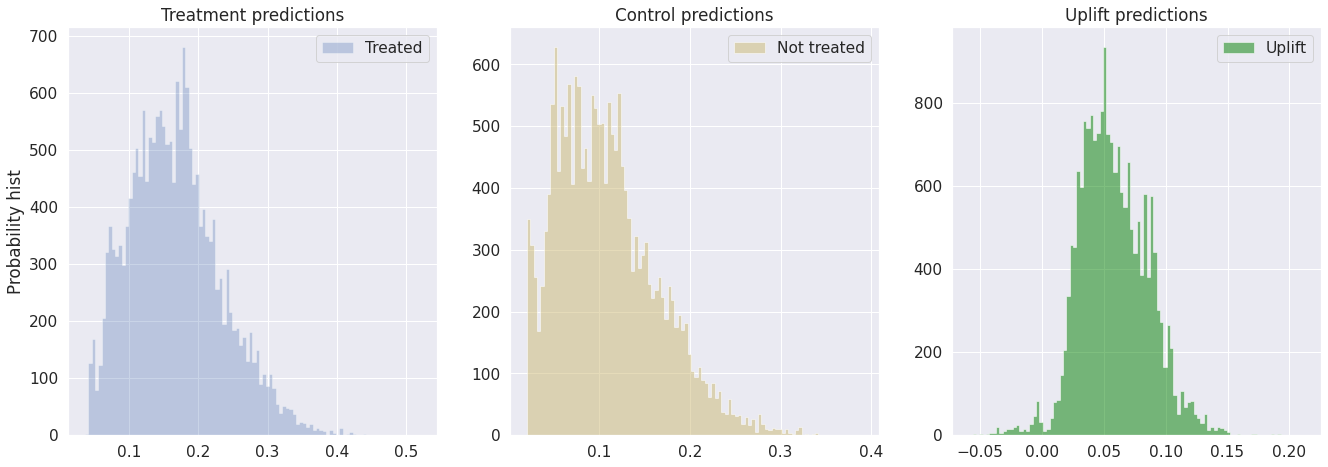

In [79]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

treat_train = X_train.treatment
treat_test = X_test.treatment

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [80]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,18.70461
1,history,14.83171
2,treatment,14.55935
3,recency,12.93096
4,used_bogo,12.76189
5,used_discount,7.56799
6,zip_code_Rural,7.25699
7,channel_Phone,4.86095
8,channel_Web,2.91927
9,zip_code_Surburban,1.58679


### Трансформация классов

In [81]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

### Две независимые модели

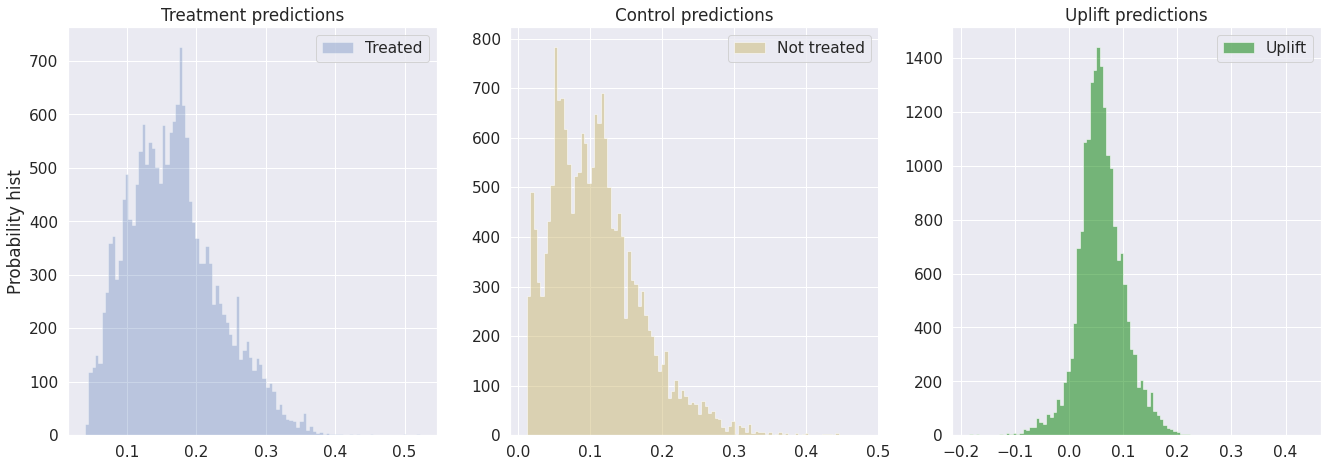

In [82]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)


models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [83]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.25439,0.20481
0,SoloModel,0.07872,0.06962
2,TwoModels,0.03300,0.06732


### UpliftTreeClassifier

In [106]:
X_train_tree = X_train
features = [col for col in X_train_tree]

In [107]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

CPU times: user 6.81 s, sys: 36.2 ms, total: 6.84 s
Wall time: 6.86 s


In [108]:
# Show graph
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

Для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift:  
1) сделать прогноз и получить uplift для тестовой выборки  
2) отсортировать тестовую выборку по uplift по убыванию  
3) разбить на децили (pandas qcut вам в помощь)  
4) для каждого дециля посчитать среднюю conversion

In [109]:
X_test_uplift = X_test
X_test_uplift['uplift'] = uplift_sm
X_test_uplift['conversion'] = y_test

In [110]:
X_test_uplift = X_test_uplift.sort_values(['uplift'], ascending=False)
X_test_uplift.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,uplift,conversion
21761,9,174.57000,0,1,0,0,0,1,0,0,1,0,0.21181,0
59142,3,209.66000,0,1,1,1,0,1,0,1,0,0,0.20393,0
49421,10,883.63000,1,1,1,1,1,0,0,1,0,0,0.19462,1
18193,7,345.13000,1,1,1,1,0,0,1,0,1,0,0.19117,0
13415,1,260.13000,1,1,1,1,0,1,0,0,0,1,0.19043,0


In [111]:
X_test_uplift['qcut']=pd.qcut(X_test_uplift['uplift'], 4, labels=False)

In [112]:
X_test_uplift

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,uplift,conversion,qcut
21761,9,174.57000,0,1,0,0,0,1,0,0,1,0,0.21181,0,3
59142,3,209.66000,0,1,1,1,0,1,0,1,0,0,0.20393,0,3
49421,10,883.63000,1,1,1,1,1,0,0,1,0,0,0.19462,1,3
18193,7,345.13000,1,1,1,1,0,0,1,0,1,0,0.19117,0,3
13415,1,260.13000,1,1,1,1,0,1,0,0,0,1,0.19043,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24075,1,29.99000,1,0,0,1,0,0,1,0,0,1,-0.05126,0,0
12749,7,68.15000,1,0,1,1,0,0,1,0,1,0,-0.05402,0,0
16636,10,32.40000,0,1,0,1,0,1,0,0,1,0,-0.05441,0,0
46845,1,751.04000,0,1,1,1,0,1,0,1,0,0,-0.05441,0,0


In [113]:
X_test_uplift_сat = X_test_uplift[X_test_uplift['qcut'] == 0]
X_test_uplift_сat['conversion'].mean()

0.14618908788004997

In [114]:
X_test_uplift_сat1 = X_test_uplift[X_test_uplift['qcut'] == 1]
X_test_uplift_сat1['conversion'].mean()

0.14496979795875858

In [115]:
X_test_uplift_сat2 = X_test_uplift[X_test_uplift['qcut'] == 2]
X_test_uplift_сat2['conversion'].mean()

0.1567319716548562

In [116]:
X_test_uplift_сat3 = X_test_uplift[X_test_uplift['qcut'] == 3]
X_test_uplift_сat3['conversion'].mean()

0.1460720983538237

### UpliftRandomForestClassifier

In [117]:
%%time
uplift_rfc = UpliftRandomForestClassifier(control_name='control', max_depth=8)

uplift_rfc.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train.values)

CPU times: user 105 ms, sys: 11.3 ms, total: 117 ms
Wall time: 19.4 s


In [120]:
graph_rfc = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

In [121]:
# Show graph
Image(graph_rfc.create_png())

Output hidden; open in https://colab.research.google.com to view.

### Save Decision Tree Image To File

In [ ]:
# Create PDF
# graph.write_pdf("Marketing_Promotion.pdf")

# Create PNG
# graph.write_png("Marketing_Promotion.png")